In [110]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [111]:
#download data
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform = transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform = transforms.ToTensor())
print(trainset) # print trainset info

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [112]:
# set up the data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=False, num_workers=2)
print('Number of batches per epoch:', len(trainloader))

Number of batches per epoch: 3125


In [113]:
# use gpu if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Using', device)

Using cpu


In [114]:
class_labels = ('plane', 'cars', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [115]:
# let's load a batch
images, labels = next(iter(trainloader))
print(images.shape, labels.shape)

torch.Size([16, 3, 32, 32]) torch.Size([16])


torchvision grid shape: torch.Size([3, 70, 274])
transposed numpy grid shape: torch.Size([70, 274, 3])


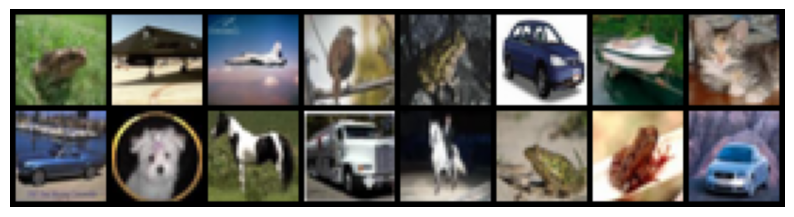

In [116]:
# lets use the makegrid function to view the batch in matplotlib
img = torchvision.utils.make_grid(images)
print('torchvision grid shape:', img.shape)
# matplotlib requires the images to have the number of channels as the last dimension
img_transposed = np.transpose(img, (1,2,0))
print('transposed numpy grid shape:', img_transposed.shape)
plt.figure(figsize=(10,5))
plt.imshow(img_transposed)
plt.axis('off')
plt.show()

In [117]:

# now we build our model
in_channels = 3
h1_channels, h2_channels = 6, 16 # hidden channels
k_conv_size = 5 # 5x5
out_dim = len(class_labels)

# let's understand how the dimensionality changes:
print('Initial Shape:'.ljust(25), images.shape)
out = nn.Conv2d(in_channels, h1_channels, k_conv_size)(images)
print('First Conv: (3, 6, 5):'.ljust(25), out.shape)
out = nn.MaxPool2d(kernel_size=2)(out)
print('Pool (2x2):'.ljust(25), out.shape)
out = nn.Conv2d(h1_channels, h2_channels, k_conv_size)(out)
print('Second Conv (6, 16, 5):'.ljust(25), out.shape)
out = nn.MaxPool2d(kernel_size=2)(out)
print('Pool (2x2):'.ljust(25), out.shape)

Initial Shape:            torch.Size([16, 3, 32, 32])
First Conv: (3, 6, 5):    torch.Size([16, 6, 28, 28])
Pool (2x2):               torch.Size([16, 6, 14, 14])
Second Conv (6, 16, 5):   torch.Size([16, 16, 10, 10])
Pool (2x2):               torch.Size([16, 16, 5, 5])


In [118]:
# now we build our model
in_channels = 3
h1_channels, h2_channels = 6, 16 # hidden channels
k_conv_size = 5 # 5x5

class CNN(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels, h1_channels, k_conv_size),
        nn.BatchNorm2d(h1_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

      self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(h1_channels, h2_channels, k_conv_size),
        nn.BatchNorm2d(h2_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

      self.fc_layer = nn.Sequential(
          nn.Linear(16 * 5 * 5, 120),
          nn.ReLU(),
          nn.Linear(120, 84),
          nn.ReLU(),
          nn.Linear(84, out_dim))

    def forward(self, x):
      x = self.conv_layer_1(x)
      x = self.conv_layer_2(x)
      x = torch.flatten(x, 1)
      x = self.fc_layer(x)
      return x

model = CNN().to(device)
# check it works
model(images.to(device)).shape

torch.Size([16, 10])

In [119]:
learning_rate = 0.001
num_epochs = 2
criterion = nn.CrossEntropyLoss() # performs softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [120]:
from tqdm import tqdm
# predict on test
model.eval() # eval mode
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in testloader:
        images, label = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs,1) # returns val, index
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    test_acc = (n_correct/n_samples) * 100
print(test_acc)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788b3bf03d00>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x788b3bf03d00>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

9.952
